---
---

# iEEG PREPROCESSING PIPELINE
### Dartmouth ECoG Lab 
#### version 1 (2021)
#### version 2 (2024) - CC edits

---
---

In [5]:
conda install --file /dartfs-hpc/rc/lab/E/ECoG/music_study_apr2024/Code/requirements.txt

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.9.0
  latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.4.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [6]:
### libraries
import pandas as pd
import mne
import numpy as np
import matplotlib as mpl
#mpl.use('TkAgg')
import matplotlib.pyplot as plt
#from mne import io, read_proj, read_custom_montage
from mne import io, read_proj
from mne.channels import read_custom_montage
from mne.datasets import sample
#from mne.time_frequency import psd_multitaper
from mne.time_frequency import psd_array_multitaper
import re 
from scipy import stats
from time import time
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [7]:
### 1. LOAD DATA:

# Load iEEG file
number = "17"
subject = "mus" + number ################################################## CHANGE: SUBJECT NAME USED FOR EXPORT
pathEDF = ('/dartfs-hpc/rc/lab/E/ECoG/music_study_apr2024/Data/' + subject + ' ieeg/Subject' + number + ' Session 1_deidentified.edf') ######################################### CHANGE: FILE PATH/NAME 
raw = mne.io.read_raw_edf(pathEDF, preload=True)
mne.set_log_level("WARNING")

# iEEG file info:
print('Data type: {}\n\n{}\n'.format(type(raw), raw))
print('Sample rate:', raw.info['sfreq'], 'Hz') # Get the sample rate
print('Size of the matrix: {}\n'.format(raw.get_data().shape)) # Get the size of the matrix
# print(raw.info) # VIEW INFO SUMMARY OF EEG DATA
# print('The actual data is just a matrix array!\n\n {}\n'.format(raw.get_data()))


Extracting EDF parameters from /dartfs-hpc/rc/lab/E/ECoG/music_study_apr2024/Data/mus17 ieeg/Subject17 Session 1_deidentified.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2372031  =      0.000 ...  4632.873 secs...
Data type: <class 'mne.io.edf.edf.RawEDF'>

<RawEDF | Subject17 Session 1_deidentified.edf, 276 x 2372032 (4632.9 s), ~4.88 GB, data loaded>

Sample rate: 512.0 Hz
Size of the matrix: (276, 2372032)



In [8]:
#plt.ion() #Makes plot interactive
#plt.switch_backend('TkAgg')
#mpl.use('Qt5Agg')
%matplotlib qt
raw.plot()
#INTRUCTIONS: Press Esc to exit once bad channels have been selected

ImportError: Cannot load backend 'Qt5Agg' which requires the 'qt' interactive framework, as 'headless' is currently running

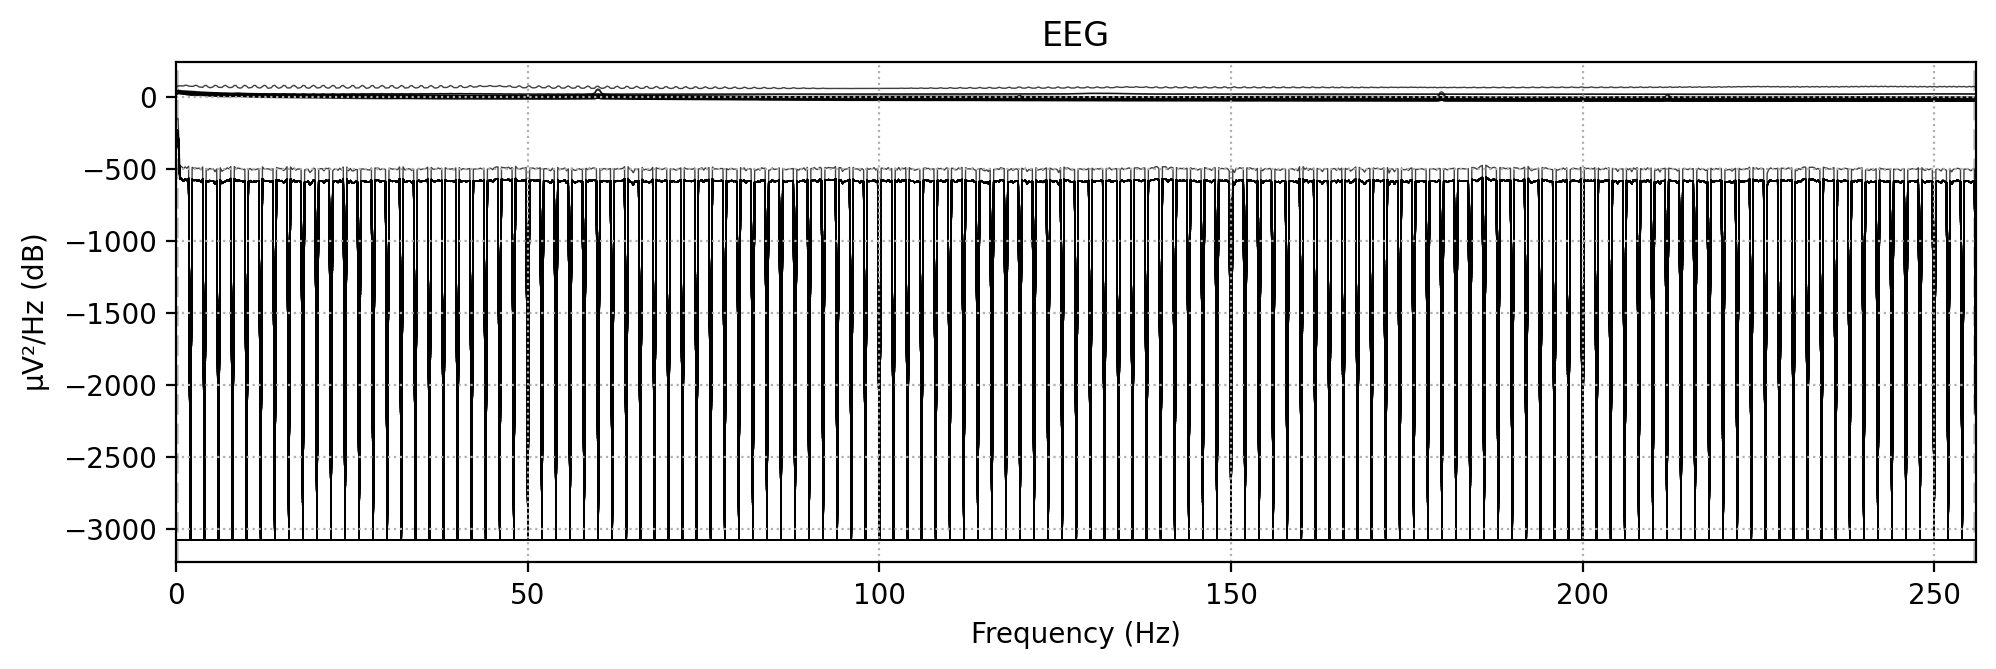

In [5]:

raw.plot_psd(tmax=np.inf, average=False)

In [23]:
### 2. CLEAN DATA:
np.bool = np.bool_ #https://stackoverflow.com/questions/74893742/how-to-solve-attributeerror-module-numpy-has-no-attribute-bool
def cleaner(raw):
    """
    iEEG PREPROCESSING PIPELINE
    INPUT: RAW iEEG (MNE)
    OUTPUT: CLEANED iEEG ('picks')
    # note: resampling should already be based on a filtered signal!
    # (i.e., first filtering, then down sampling)
    """
    ### 1. rereference data (average rereference)
    raw.set_eeg_reference('average', projection=True)
    # raw.plot_psd(area_mode='range', tmax=10.0) # visual verification
    #raw.plot_psd(area_mode='range', tmax=10.0) # visual verification

    print('Original sampling rate:', raw.info['sfreq'], 'Hz')

    ### 2. notch filter
    raw = raw.notch_filter(np.arange(60, int(raw.info['sfreq']/2)-1, 60), filter_length='auto', phase='zero') # 60, 241, 60
    # raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
    #              n_jobs=1, proj=True, ax=ax, color=(1, 0, 0), picks=picks) # visual verification
    #raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
    #              n_jobs=1, proj=True, ax=ax, color=(1, 0, 0), picks=picks) # visual verification

    ### 3. other filters 
    # low pass filter (250Hz)
    raw = raw.filter(None, 250., h_trans_bandwidth='auto', filter_length='auto', phase='zero')
    # high pass filter (1Hz) - remove slow drifts
    raw = raw.filter(1., None, l_trans_bandwidth='auto', filter_length='auto', phase='zero')
    # raw.plot_psd(area_mode='range', tmax=10.0) # visual verification
    #raw.plot_psd(area_mode='range', tmax=10.0) # visual verification


    ### 4. downsampling (200Hz)
    raw = raw.resample(200, npad='auto')
    print('New sampling rate:', raw.info['sfreq'], 'Hz')
    
    ### 5. reject bad channels
    def check_bads_adaptive(raw, picks, fun=np.var, thresh=3, max_iter=np.inf):
        ch_x = fun(raw[picks, :][0], axis=-1)
        my_mask = np.zeros(len(ch_x), dtype=np.bool)
        i_iter = 0
        while i_iter < max_iter:
            ch_x = np.ma.masked_array(ch_x, my_mask)
            this_z = stats.zscore(ch_x)
            local_bad = np.abs(this_z) > thresh
            my_mask = np.max([my_mask, local_bad], 0)
            print('iteration %i : total bads: %i' % (i_iter, sum(my_mask)))        
            if not np.any(local_bad): 
                break
            i_iter += 1
        bad_chs = [raw.ch_names[i] for i in np.where(ch_x.mask)[0]]
        return (bad_chs)
    # Find the first index of the super-bad channels
    endIndex = 1
    for i, name in enumerate(raw.info['ch_names']): # can add new logic to reject other channels that are definitely bad
        if len(re.compile(r'C\d{3}').findall(name)) > 0:
            endIndex = i
            break
    bad_chs = raw.ch_names[endIndex:]
    bad_chs.extend(check_bads_adaptive(raw, list(range(0,endIndex)), thresh=3)) 
    raw.info['bads'] = bad_chs
    #     print(bad_chs)
    #     print(len(raw.info['bads'])) # check which channels are marked as bad
    ### PICK ONLY GOOD CHANNELS:
    picks = raw.pick_types(eeg = True, meg = False, exclude = 'bads')
    print("NUMBER OF CHANNELS FOR SUBJECT {}: {}".format(subject,len(picks.info['chs'])))
    #     print("THIS SHOULD BE 0: {}".format(len(picks.info['bads'])) ) # check statement
    
    return (picks)

picks = cleaner(raw)


Original sampling rate: 512.0 Hz
New sampling rate: 200.0 Hz
iteration 0 : total bads: 8
iteration 1 : total bads: 14
iteration 2 : total bads: 18
iteration 3 : total bads: 18
NUMBER OF CHANNELS FOR SUBJECT mus18: 217


['RTMA2', 'RTMA3', 'RTMA4', 'RTMA5', 'RTMA6', 'RTMA7', 'RTMA8', 'RTMA9', 'RTMA10', 'RTMA11', 'RTMA12', 'RTMHA1', 'RTMHA2', 'RTMHA3', 'RTMHA4', 'RTMHA5', 'RTMHA6', 'RTMHA7', 'RTMHA8', 'RTMHA9', 'RTMHA10', 'RTMHA11', 'RTMHA12', 'RTMHB1', 'RTMHB4', 'RTMHB5', 'RTMHB6', 'RTMHB7', 'RTMHB8', 'RTMHB9', 'RTMHB10', 'RTMHB11', 'RTMHB12', 'RTSP5', 'RTSP6', 'RTSP7', 'RTSP8', 'RTSP9', 'RTSP10', 'RTSP11', 'RTSP12', 'RTSP13', 'RTSP14', 'RTSP15', 'RTSP16', 'RTSF3', 'RTSF4', 'RTSF5', 'RTSF6', 'RTSF7', 'RTSF8', 'RTSF9', 'RTSF10', 'RTSF11', 'RTSF12', 'RTSF13', 'RTSF14', 'LTMA1', 'LTMA2', 'LTMA3', 'LTMA4', 'LTMA5', 'LTMA6', 'LTMA7', 'LTMA8', 'LTMA9', 'LTMA10', 'LTMA11', 'LTMA12', 'LTMH3', 'LTMH4', 'LTMH5', 'LTMH6', 'LTMH7', 'LTMH8', 'LTMH9', 'LTMH10', 'LTMH11', 'LTMH12', 'RFMCA1', 'RFMCA2', 'RFMCA3', 'RFMCA4', 'RFMCA5', 'RFMCA6', 'RFMCA7', 'RFMCA8', 'RFMCA9', 'RFMCA10', 'RFMCA11', 'RFMCA12', 'RFMCA13', 'RFMCA14', 'RFMO1', 'RFMO2', 'RFMO3', 'RFMO4', 'RFMO5', 'RFMO6', 'RFMO7', 'RFMO8', 'RFMO9', 'RFMO10', 'RF

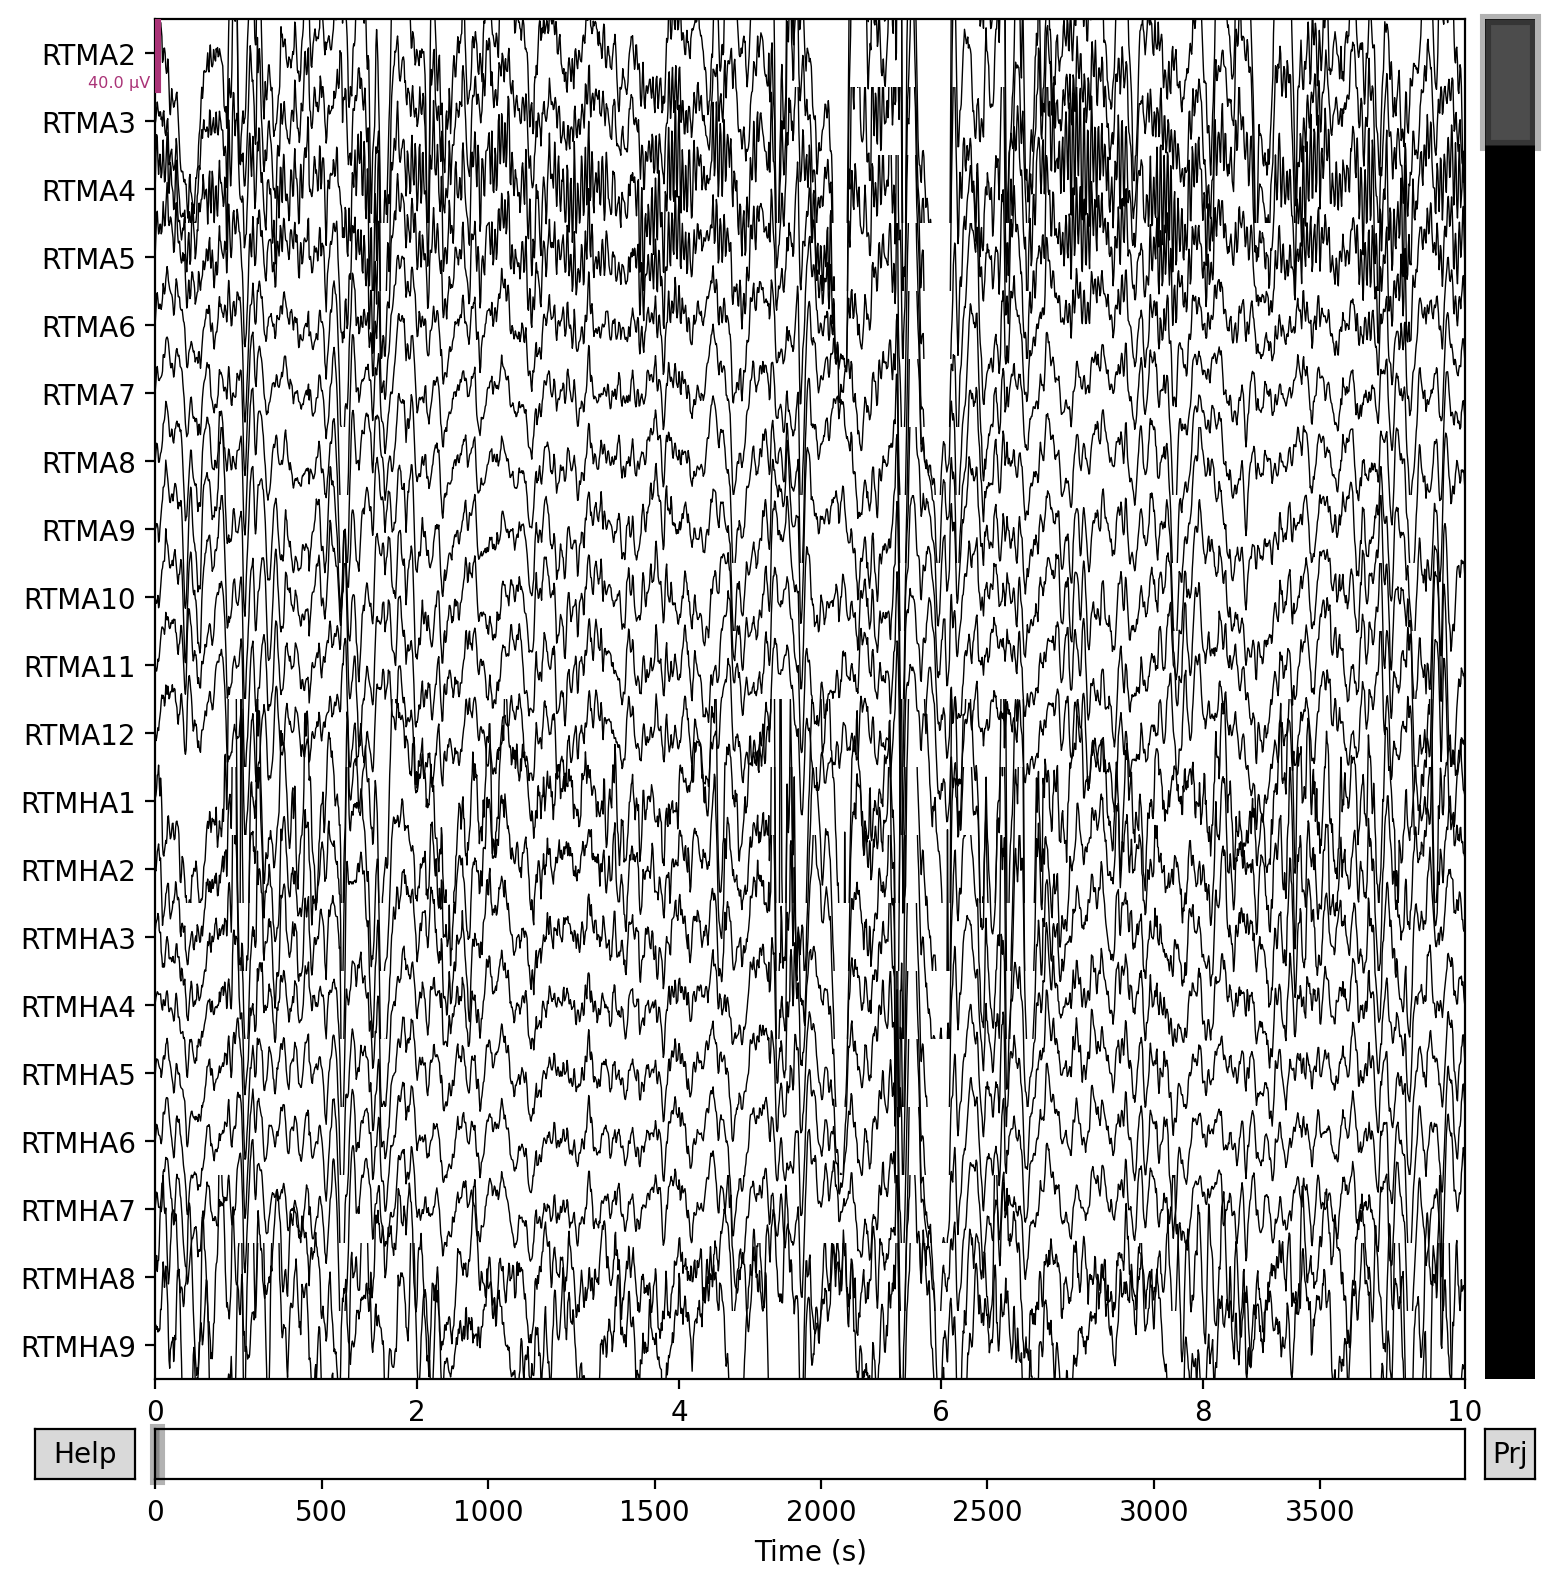

In [24]:
#REMOVE AUXILIARY/BAD CHANNELS
#test_eeg = picks.pick_types(meg = False)
#picks.ch_names
#picks.pick_types(exclude = ['DC3', 'DC4'])
#picks.info
#https://mne.tools/stable/auto_tutorials/preprocessing/15_handling_bad_channels.html
print(picks.ch_names)
picks.plot()

In [26]:
#RUN TWICE TO ENSURE BAD CHANNELS HAVE BEEN REMOVED
print(picks.info['bads'])
print(picks.ch_names)
test = picks.pick_types(eeg = True, meg = False, exclude='bads')

[]
['RTMA2', 'RTMA3', 'RTMA4', 'RTMA5', 'RTMA6', 'RTMA7', 'RTMA8', 'RTMA9', 'RTMA10', 'RTMA11', 'RTMA12', 'RTMHA1', 'RTMHA2', 'RTMHA3', 'RTMHA4', 'RTMHA5', 'RTMHA6', 'RTMHA7', 'RTMHA8', 'RTMHA9', 'RTMHA10', 'RTMHA11', 'RTMHA12', 'RTMHB1', 'RTMHB4', 'RTMHB5', 'RTMHB6', 'RTMHB7', 'RTMHB8', 'RTMHB9', 'RTMHB10', 'RTMHB11', 'RTMHB12', 'RTSP5', 'RTSP6', 'RTSP7', 'RTSP8', 'RTSP9', 'RTSP10', 'RTSP11', 'RTSP12', 'RTSP13', 'RTSP14', 'RTSP15', 'RTSP16', 'RTSF3', 'RTSF4', 'RTSF5', 'RTSF6', 'RTSF7', 'RTSF8', 'RTSF9', 'RTSF10', 'RTSF11', 'RTSF12', 'RTSF13', 'RTSF14', 'LTMA1', 'LTMA2', 'LTMA3', 'LTMA4', 'LTMA5', 'LTMA6', 'LTMA7', 'LTMA8', 'LTMA9', 'LTMA10', 'LTMA11', 'LTMA12', 'LTMH3', 'LTMH4', 'LTMH5', 'LTMH6', 'LTMH7', 'LTMH8', 'LTMH9', 'LTMH10', 'LTMH11', 'LTMH12', 'RFMCA1', 'RFMCA2', 'RFMCA3', 'RFMCA4', 'RFMCA5', 'RFMCA6', 'RFMCA7', 'RFMCA8', 'RFMCA9', 'RFMCA10', 'RFMCA11', 'RFMCA12', 'RFMCA13', 'RFMCA14', 'RFMO1', 'RFMO2', 'RFMO3', 'RFMO4', 'RFMO5', 'RFMO6', 'RFMO7', 'RFMO8', 'RFMO9', 'RFMO10', 

In [27]:
### EXPORT DATA:
# export picks as .csv 
header = ','.join(picks.ch_names)
np.savetxt('./'+subject+'_eegdata.csv', picks.get_data().T, delimiter=',', header=header) ### ---> spike detection


# END